# Running a wavelet computation on a $CH_4$ molecule

The purpose of this lesson is to get familiar with the basic variables needed to run a wavelet computation in isolated boundary conditions. At the end of the lesson, you can run a wavelet run, check the amount of needed memory and understand the important part of the output.
We propose to use python in a Jupyter notebook to simplify the use of the `bigdft` executable and to have tools to combine pre-processing, execution, post-processing and analysis.

## Introduction: Running the code

`bigdft` uses dictionaries (a collection of pairs of key and value) for the input and output which are serialized by means of the yaml format.
For an explanation of the yaml format, you can read the file [Tutorial-yaml.ipynb](./Tutorial-yaml.ipynb).

So it is equivalent to use python dictionary as:

In [1]:
from BigDFT import Calculators as calc

inp = { 'dft': { 'hgrids': 0.55, 'rmult': [3.5, 9.0], 'nrepmax': 'accurate' } }

Beside a default input file called **input.yaml**, BigDFT requires the atomic positions for the studied system and optionaly the pseudo-potential files. 
For the following tutorial, a methane molecule will be used. 
The position file is a simple XYZ file named [CH4_posinp.xyz](CH4_posinp.xyz):
<pre>
5  angstroemd0  # methane molecule
free
C        0           0           0
H       -0.63169789 -0.63169789 -0.63169789
H       +0.63169789 +0.63169789 -0.63169789
H       +0.63169789 -0.63169789 +0.63169789
H       -0.63169789 +0.63169789 +0.63169789
</pre>

We can copy this file into the default posinp file **posinp.xyz** as ``cp CH4_posinp.xyzz posinp.xyz`` or indicate it 
in the input dictionary:

In [2]:
inp['posinp'] = 'CH4_posinp.xyz'

The pseudo-potential files are following the ABINIT structure and are of GTH or HGH types 
(see the [pseudo-potential file page](https://www.abinit.org/psp-tables) on the
ABINIT website for several LDA and GGA files and the
[page](https://www.cp2k.org/static/potentials/) on the CP2K server for HGH pseudo for several functionals). 
The following files may be used for this tutorial: [**psppar.C**](./psppar.C) and [**psppar.H**](./psppar.H).

Warning, to run properly, the pseudo-potential files must be **psppar.XX** where XX is the symbol used in the position file.
The other files can have user-defined names, as explained in [Tutorial-N2.ipynb](./Tutorial-N2.ipynb) lesson.
If the code has been compiled with MPI capabilities (which is enabled by default), running BigDFT on several cores is as easy as run
it as a serial job. There is no need to change anything in the input files.

Running BigDFT is done using the ``bigdft`` executable in a standard Unix way.
In this notebook, we use the SystemCalculator class:

In [3]:
study = calc.SystemCalculator() #Create a calculator
ch4 = study.run(input=inp)

Initialize a Calculator with OMP_NUM_THREADS=1 and command /local/deutsch/Forge/BigDFT/build-mpif90/install/bin/bigdft
Creating the yaml input file "input.yaml"
Executing command:  /local/deutsch/Forge/BigDFT/build-mpif90/install/bin/bigdft


*ch4* is the instance of the class Logfile which can handle easily all information coming from the output file **log.yaml**.
Then we can display some information as:

In [4]:
print ch4

- Atom types:
  - C
  - H
- Cell: Free BC
- Convergence criterion on forces: 0.0
- Max val of Forces: 0.0214711014196
- Energy: -8.02521436642915
- Symmetry group: disabled
- fermi_level: -0.3414840466884
- Number of Atoms: 5
- Convergence criterion on Wfn. Residue: 0.0001
- No. of KS orbitals:
  - 4



## The wavelet basis set, a convergence study
The wavelet is a systematic basis set (as plane waves are), which means than one can increase arbitrarily the accuracy of the results by varying some parameters which are defined in the `dft` dictionary (`inp['dft']`).

![CH4-grid](http://bigdft.org/images/7/72/CH4-grid.png)

**`hgrids`**
      are used to set up the basis set. In free boundary conditions, the basis set is characterised
      by a spatial expansion and a grid step, as shown in the side figure.
      There is ''one float value'' describing the ''grid steps'' in the three space directions (''i.e.'' x, y and z)
      or a 3D array is also accepted.
      These values are in bohr unit and typically range from 0.3 to 0.65. The
      harder the pseudo-potential, the lower value should be set up.
      These values are called `hgrids`.
        
**`rmult`**
      contains an array of two float values that are two multiplying factors.
      They multiply quantities that are chemical species dependent.
      The first factor is the most important since it
      describes ''the spatial expansion'' of the basis set (in yellow on the figure beside).
      Indeed the basis set is defined as a set of real space points with non-zero values.
      These points are on a global regular mesh and located inside spheres centered on atoms.
      The first multiplying factor is called `crmult` for Coarse grid Radius MULTiplier.
      Increasing it means that further spatial expansion is possible for the wavefunctions. 
      Typical values are 5 to 7.
      The second one called `frmult` for Fine grid Radius MULTiplier is related to the fine resolution.
      This parameter is less pertinent for the convergence of energy and can be ignored.
      It is possible to indicate only one float value, the `crmult` parameter.

## Exercise 

Run BigDFT for the following values of *hgrid* and *crmult* and plot the total energy convergence versus `hgrids`. 
The final total energy can be retrieved using th emethod `energy` from the result of the command `study.run`, the value is in Hartree. 
A comprehensive explanation of the screen output will be given later in this tutorial.

<pre>
hgrids = 0.55bohr / crmult = 3.5
hgrids = 0.50bohr / crmult = 4.0
hgrids = 0.45bohr / crmult = 4.5
hgrids = 0.40bohr / crmult = 5.0
hgrids = 0.35bohr / crmult = 5.5
hgrids = 0.30bohr / crmult = 6.0
hgrids = 0.25bohr / crmult = 6.5
hgrids = 0.20bohr / crmult = 7.0</pre>


This precision plot shows the systematicity of the wavelet basis set: by improving the basis set, we improve the value of the total energy.

To go further, one can vary `hgrids` and `crmult` independently.
This is shown in the previous figure with the grey line. 
The shape of the convergence curve shows that both these parameters should be modified simoultaneously in order to increase accuracy. 
Indeed, there are two kind of errors arising from the basis set. 
The first one is due to the fact the basis set can't account for quickly varying wavefunctions (value of `hgrids` should be decreased). 
The second error is the fact that the wavefunctions are constrained to stay inside the defined basis set (output values are zero). 
In the last case `crmult` should be raised.

In [5]:
results = []
Hgrids = []
hgrids = 0.55
crmult = 3.5
#First curve varying both hgrids and crmult
while hgrids >= 0.20:
    inp['dft']['hgrids'] = hgrids
    inp['dft']['rmult'] = crmult
    print 'hgrids=',hgrids,'crmult=',crmult
    results.append(study.run(input=inp))
    Hgrids.append(hgrids)
    hgrids -= 0.05
    crmult += 0.5

#Second curve varying only hgrids with crmult=3.5
crmult = 3.5
hgrids = 0.55
res2 = [ results[0] ]
while hgrids > 0.25:
    hgrids -= 0.05
    inp['dft']['hgrids'] = hgrids
    inp['dft']['rmult'] = crmult
    print 'hgrids=',hgrids,'crmult=',crmult
    res2.append(study.run(input=inp))

hgrids= 0.55 crmult= 3.5
Creating the yaml input file "input.yaml"
Executing command:  /local/deutsch/Forge/BigDFT/build-mpif90/install/bin/bigdft
hgrids= 0.5 crmult= 4.0
Creating the yaml input file "input.yaml"
Executing command:  /local/deutsch/Forge/BigDFT/build-mpif90/install/bin/bigdft
hgrids= 0.45 crmult= 4.5
Creating the yaml input file "input.yaml"
Executing command:  /local/deutsch/Forge/BigDFT/build-mpif90/install/bin/bigdft
hgrids= 0.4 crmult= 5.0
Creating the yaml input file "input.yaml"
Executing command:  /local/deutsch/Forge/BigDFT/build-mpif90/install/bin/bigdft
hgrids= 0.35 crmult= 5.5
Creating the yaml input file "input.yaml"
Executing command:  /local/deutsch/Forge/BigDFT/build-mpif90/install/bin/bigdft
hgrids= 0.3 crmult= 6.0
Creating the yaml input file "input.yaml"
Executing command:  /local/deutsch/Forge/BigDFT/build-mpif90/install/bin/bigdft
hgrids= 0.25 crmult= 6.5
Creating the yaml input file "input.yaml"
Executing command:  /local/deutsch/Forge/BigDFT/build-

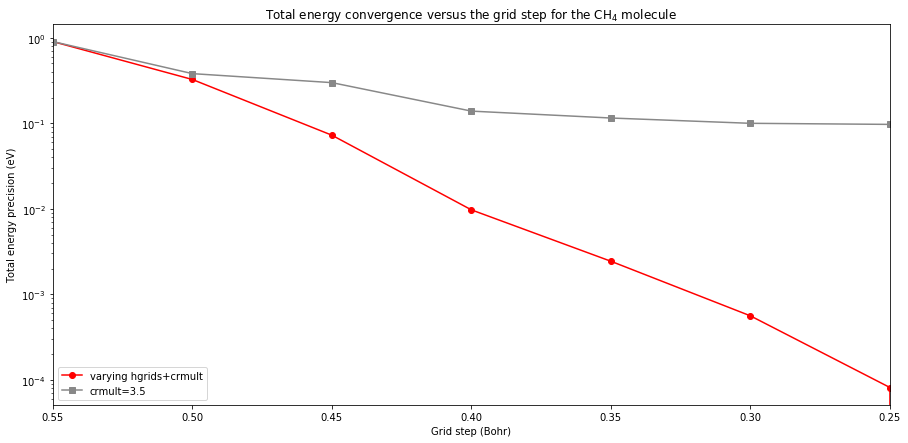

In [6]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

HtoeV = 27.21138386 #Conversion Hartree to meV

emin = HtoeV*results[-1].energy
ener = [ HtoeV*l.energy - emin for l in results ]

ener2 = [ HtoeV*l.energy - emin for l in res2 ]

plt.figure(figsize=(15,7))
# Plot with matplotlib
plt.plot(Hgrids, ener,  marker='o', ls='-', color='#ff0000', label='varying hgrids+crmult')  
plt.plot(Hgrids, ener2, marker='s', ls='-', color='#888888', label='crmult=3.5')  

plt.yscale('log')
plt.xlim(0.55,0.25)
plt.xlabel('Grid step (Bohr)')
plt.ylabel('Total energy precision (eV)')
plt.title('Total energy convergence versus the grid step for the CH$_4$ molecule')
plt.legend(loc=3)
plt.show()

## Fine tuning of the basis set
The multi-scale property of the wavelets is used in BigDFT and a two level grid is used for the calculation. 
We've seen previously the coarse grid definition using the the multiplying factor `rmult`. 
The second multiplying value on this line of the input file is used for the fine grid and is called `frmult`. 
Like `crmult`, it defines a factor for the radii used to define the fine grid region where the number of degrees of freedom
is indeed eight times the one of the coarse grid. It allows to define region
near the atoms where the wavefunctions are allowed to vary more
quickly. Typical values for this factor are 8 to 10. It's worth to
note that even if the value of the multiplier is greater than `crmult` it defines a smaller region due to the fact that
the units which are associated to these radii are significantly different.

The physical quantities used by `crmult` and `frmult` can be changed in the pseudo-potential by adding
an additional line with two values in bohr. The two values that the
code is using (either computed or read from the pseudo-potential files) are output in the following way in the screen output:
        
<pre>
 - Symbol                              : C #Type No.  01
   No. of Electrons                    :  4
   No. of Atoms                        :  1
   Radii of active regions (AU):
     Coarse                            :  1.58437
     Fine                              :  0.30452
     Coarse PSP                        :  1.30510
     Source                            : Hard-Coded
 - Symbol                              : H #Type No.  02
   No. of Electrons                    :  1
   No. of Atoms                        :  4
   Radii of active regions (AU):
     Coarse                            :  1.46342
     Fine                              :  0.20000
     Coarse PSP                        :  0.00000
     Source                            : Hard-Coded</pre>

## Analysing the output

The output of BigDFT is divided into four parts:
* Input values are printed out, including a summary of the
  different input files (DFT calculation parameters, atom positions,
  pseudo-potential values...);
* Input wavefunction creation, usually called "input guess";
* The SCF (Self-Consistent Field) loop itself;
* The post SCF calculations including the forces calculation and
  other possible treatment like a finite size effect estimation or a
  virtual states determination.

### The system parameters output
All the read values from the different input files are printed
out at the program startup. Some additional values are provided there
also, like the memory consumption. Values are given for one process,
which corresponds to one core in an MPI environment.

In [7]:
import yaml
print yaml.dump(ch4.memory)

print 'Estimated Memory Peak',ch4.memory_peak,'MB'

Accumulated memory requirements during principal run stages (MiB.KiB): {Density Construction: 23.723,
  Hamiltonian application: 23.922, Kernel calculation: 39.271, Orbitals Orthonormalization: 23.922,
  Poisson Solver: 36.205}
Estimated Memory Peak (MB): 39
Memory requirements for principal quantities (MiB.KiB): {All (distributed) orbitals: 0.749,
  Full Uncompressed (ISF) grid: 3.224, Nonlocal Pseudopotential Arrays: 0.46, Single orbital: 0.94,
  Subspace Matrix: 0.1, Wavefunction storage size: 5.123, Workspaces storage size: 0.211}

Estimated Memory Peak 39 MB


The overall memory requirement needed for this calculation is thus: 39 MB (Estimated Memory Peak) which is provided by the`memory_peak` attribute.

In this example, the memory requirement is given for one process run and the peak of memory will be in the initialisation during the Kernel calculation, while the SCF loop will reach 36MB during the Poisson solver calculation. For bigger systems, with more orbitals, the peak of memory is usually reached during the Hamiltonian application.

### Exercise

Run a script to estimate the memory requirement of a run before submitting it to the queue system of a super-computer
using the `dry_run` option.

It reads the same input, and is thus convenient to validate inputs.

Try several values from 1 to 6 and discuss the memory distribution.

In [8]:
study = calc.SystemCalculator(dry_run=True) #Create a calculator
peak = []
for i in range(1,7):
    study.set_global_option('dry_mpi',i)
    dry = study.run(input=inp)
    peak.append(dry.memory_peak)
    print yaml.dump(dry.memory,default_flow_style=False)
for i,p in enumerate(peak):
    print "mpi=",i+1,"Estimated memory peak (MB)",p

Initialize a Calculator with OMP_NUM_THREADS=1 and command /local/deutsch/Forge/BigDFT/build-mpif90/install/bin/bigdft
Creating the yaml input file "input.yaml"
Executing command:   /local/deutsch/Forge/BigDFT/build-mpif90/install/bin/bigdft-tool -l -n 1
Accumulated memory requirements during principal run stages (MiB.KiB):
  Density Construction: 240.179
  Hamiltonian application: 242.635
  Kernel calculation: 350.242
  Orbitals Orthonormalization: 242.635
  Poisson Solver: 347.662
Estimated Memory Peak (MB): 350
Memory requirements for principal quantities (MiB.KiB):
  All (distributed) orbitals: 9.35
  Full Uncompressed (ISF) grid: 29.538
  Nonlocal Pseudopotential Arrays: 0.424
  Single orbital: 1.172
  Subspace Matrix: 0.1
  Wavefunction storage size: 65.402
  Workspaces storage size: 2.73

Creating the yaml input file "input.yaml"
Executing command:   /local/deutsch/Forge/BigDFT/build-mpif90/install/bin/bigdft-tool -l -n 2
Accumulated memory requirements during principal run stag

BigDFT distributes the orbitals over the available processes.
The value `All (distributed) orbitals` does not decrease anymore after 4 processes since there are only 4 bands in our example). 
This means that running a parallel job with more processors than orbitals will result in a bad speedup. 
The number of cores involved in the calculation might be however increased via OMP parallelisation, as it is indicated in [Scalability with MPI and OpenMP](./Tutorial-Scalability.ipynb) lesson.


## The input guess
The initial wavefunctions in BigDFT are calculated using the atomic orbitals for all the electrons of the s, p,
d shells, obtained from the solution of the PSP self-consistent equation for the isolated atom.

In [9]:
print yaml.dump(ch4.log['Input Hamiltonian'])

Accuracy estimation for this run: {Convergence Criterion: 0.00102, Energy: 0.00408}
Atomic Input Orbital Generation:
- Atom Type: C
  Electronic configuration:
    p: [2/3, 2/3, 2/3]
    s: [2.0]
- Atom Type: H
  Electronic configuration:
    s: [1.0]
Deviation from normalization: 0.000283
EKS: -7.159653160338806
Energies: {EH: 15.0389122216, EXC: -3.14884745743, Ekin: 7.21088056472, Enl: 0.774148885702,
  Epot: -10.5898361897, EvXC: -4.11747215738}
Expected kinetic energy: 7.2067994418
GPU acceleration: false
IG wavefunctions defined: true
Input Guess Overlap Matrices: {Calculated: true, Diagonalized: true}
Orbitals:
- {e: -0.6493539153869, f: 2.0}
- {e: -0.3625626366055, f: 2.0}
- {e: -0.3624675839372, f: 2.0}
- {e: -0.3624675839372, f: 2.0}
- {e: 0.3980916655348, f: 0.0}
- {e: 0.3983087771728, f: 0.0}
- {e: 0.3983087771728, f: 0.0}
- {e: 0.5993393223683, f: 0.0}
Poisson Solver:
  BC: Free
  Box: [75, 75, 75]
  MPI tasks: 1
Total No. of Atomic Input Orbitals: 8
Total electronic charg

The corresponding hamiltonian is then diagonalised and the
n_band (``norb`` in the code notations) lower eigenfunctions are used to start the SCF loop. 
BigDFT outputs the eigenvalues, in the following example, 8 electrons were used in the
input guess and the resulting first fourth eigenfunctions will be used
for a four band calculation.

<pre>
Input Guess Overlap Matrices: {Calculated: true, Diagonalized: true}
Orbitals:
- {e: -0.6493539153869, f: 2.0}
- {e: -0.3625626366055, f: 2.0}
- {e: -0.3624675839372, f: 2.0}
- {e: -0.3624675839372, f: 2.0} -- Last InputGuess eval, H-L IG gap:  20.6959 eV
- {e: 0.3980916655348, f: 0.0}  -- First virtual eval
- {e: 0.3983087771728, f: 0.0}
- {e: 0.3983087771728, f: 0.0}
- {e: 0.5993393223683, f: 0.0}
</pre>

## The SCF loop
The SCF loop follows a direct minimisation scheme and is made of the following steps:
* Calculate the charge density from the previous wavefunctions.
* Apply the Poisson solver to obtain the Hartree potential from the
  charges and calculate the exchange-correlation energy and the energy
  of the XC potential thanks to the chosen functional.
* Apply the resulting hamiltonian on the current wavefunctions.
* Precondition the result and apply a steepest descent or a DIIS
  history method. This depends on ``idsx``, not specified in the
  present input. It is therefore set to the default
  value, which is 6 (for an history of 6 previous set of vectors. To perform a SD 
  minimisation one should add "``idsx: 0``" to the *dft* dictionary of *inp*.
* Orthogonalise the new wavefunctions.

Finally the total energy and the square norm of the residue
(gnrm) are printed out. The *gnrm* value is the stopping criterion. 
It can be chosen using `gnrm_cv` in the *dft* dictionary. 
The default value (1e-4) is used here and a good value can reach 1e-5.

In [10]:
print 'gnrm_cv by default',ch4.gnrm_cv

gnrm_cv by default 0.0001


The minimisation scheme coupled with DIIS (and thanks to the good preconditioner) 
is a very efficient way to obtain convergence for systems with a gap, even with a very small one. 
Usual run should reach the 1e-4 stop criterion within 15 to 25 iterations. 
Otherwise, there is an issue with the system, either there is no gap, 
or the input guess is too symmetric due to the LCAO diagonalization, specific spin polarization...

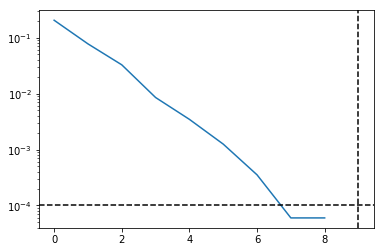

In [11]:
ch4.wfn_plot()

### The post-SCF treatments
At the end of the SCF loop, a diagonalisation of the current hamiltonian is done to obtain Kohn-Sham eigenfunctions. The
corresponding eigenvalues are also given.

In [12]:
print ch4.evals

[BandArray([[-0.6164673 , -0.34150619, -0.34148405, -0.34148405]])]


The forces are then calculated.

In [13]:
print yaml.dump(ch4.forces,default_flow_style=False)

- C:
  - -9.330684410542e-06
  - -9.330684413021e-06
  - -9.330684363889e-06
- H:
  - 0.0123963461844
  - 0.01239634618441
  - 0.0123963461844
- H:
  - -0.01234495856958
  - -0.01234495856959
  - 0.01230290163917
- H:
  - -0.01234495856958
  - 0.01230290163918
  - -0.0123449585696
- H:
  - 0.01230290163918
  - -0.01234495856959
  - -0.0123449585696



Some other post-SCF may be done depending on the parameters in the *dft* dictionary of *inp*.

### Exercise
Run `bigdft` when varying the DIIS history length and discuss the memory consumption.

Reducing the DIIS history is a good way to reduce the memory consumption when one cannot increase the
number of processes. Of course this implies more iterations in SCF loops.

## Adding a charge
BigDFT can treat charged system without the requirement to add a compensating background like in plane waves.
The additional charge to add to the system is set in the *dft* dictionary with the *qcharge* key. 
In the following example an electron has been added (-1):

In [14]:
inp3 = {}
inp3['dft'] = { 'hgrids': 0.55, 'nrepmax': 'accurate' }
inp3['posinp'] = 'CH3-_posinp.xyz'

### Exercise 
Remove the last hydrogen atom in the previous methane example and modify to add an electron. 
Then run BigDFT for an electronic convergence.

One can notice that the total charge in the system is indeed -8 thanks to the additional charge. 
The convergence rate is still good for this CH$_3^-$ radical since it is a closed shell system.

Initialize a Calculator with OMP_NUM_THREADS=1 and command /local/deutsch/Forge/BigDFT/build-mpif90/install/bin/bigdft
Creating the yaml input file "input.yaml"
Executing command:  /local/deutsch/Forge/BigDFT/build-mpif90/install/bin/bigdft
- Atom types:
  - C
  - H
- Cell: Free BC
- Convergence criterion on forces: 0.0
- Max val of Forces: 0.04637974703569
- Energy: -7.325181238047086
- Symmetry group: disabled
- fermi_level: -0.1956187539288
- Number of Atoms: 4
- Convergence criterion on Wfn. Residue: 0.0001
- No. of KS orbitals:
  - 4



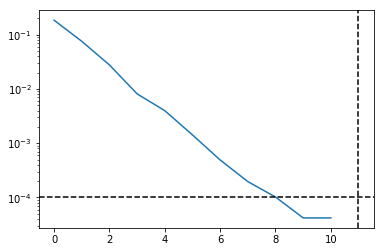

In [15]:
study = calc.SystemCalculator() #Use a new calculator)
ch3m = study.run(input=inp3)
print ch3m
ch3m.wfn_plot()

## Running a geometry optimisation
In the previous charged example the geometry of the radical is kept the same than for the methane molecule, while it is likely to
change. One can thus optimize the geometry with BigDFT.

To run geometry calculations (molecular dynamics, structure
optimisations...) one should add another dictionary *geopt* in the input which contains the method to use.

In the log file, all input variables are indicated with their default value.

Here, we look for a local minimum so we can use the keyword `LBFGS`.
We can add also the stopping criteria.
There are two stopping criteria: the first `ncount_cluster_x` being the number of loops (force evaluations) and the second `forcemax` is the maximum on forces. For isolated systems, the first criterion is well adapted
while the second is good for periodic boundary conditions.

In [16]:
inpg = {}
inpg['dft'] = { 'hgrids': 0.55, 'nrepmax': 'accurate' }
inpg['posinp'] = 'CH4_posinp.xyz'
inpg['geopt'] = { 'method': 'LBFGS', 'ncount_cluster_x': 20}
study = calc.SystemCalculator() #Use a new calculator)
ch4geopt = study.run(input=inpg)

Initialize a Calculator with OMP_NUM_THREADS=1 and command /local/deutsch/Forge/BigDFT/build-mpif90/install/bin/bigdft
Creating the yaml input file "input.yaml"
Executing command:  /local/deutsch/Forge/BigDFT/build-mpif90/install/bin/bigdft
('Found', 19, 'different runs')


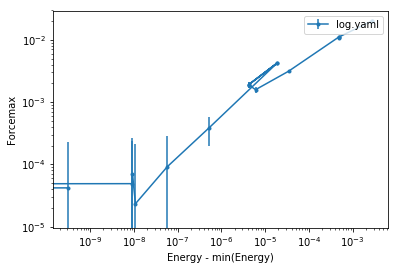

In [17]:
%matplotlib inline
ch4geopt.geopt_plot()

### Exercise
Take the CH$_3^-$ radical [**CH3-_posinp.xyz**](./CH3-_posinp.xyz) file and run a geometry optimisation.

The evolution of the forces during relaxation can be easily obtained using the `geop_plot` function to the result of the calculation.

At each iteration, BigDFT outputs a file **posout_XXXX.xyz** in the directory **data** with the geometry of the iteration
XXX. You can visualize it using v_sim (select all files in the "Browser" tab).